In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('dialect_results.csv')
del df["hypoparsr"]

red = "#D81B60"
yellow = "#FFC107"
blue = "#1E88E5"
green = "#004D40"
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

True
D:\HPI\docker\csv_bert\results\dialect\\clevercs_full\clevercs_dev_augmented_complete_results.csv None


In [15]:
import sklearn.metrics
rootpath = "D:\\HPI\\docker\\csv_bert\\results\\dialect\\"
df_dicts = []
dataset_paths = { "dev":"_dev_augmented_complete_results.csv", 
                #  "dev" : "_overall_original_results.csv",
                 "test":"_test_original_results.csv",
                 "weird":"_weird_original_results.csv"}

results_df = {}
for dataset,path in dataset_paths.items():

    #Hybrid: we rely on magritte if it says the delimiter is ',', otherwise we rely on clevercsv
    # we rely on magritte if it says the quotechar is '"', otherwise we rely on clevercsv
    # we rely on magritte if it says the escapechar is '', otherwise we rely on clevercsv
    # Why? Because magritte was trained on a balanced dataset, it tends to overestimate the probability that 
    # the dialect characters are "weird", while being very confident about the delimiter being ','.
    # If magritte says that the delimiter is other than comma, we resort to clevercsv to corroborate the decision of magritte.

    # while clevercsv was trained on a dataset that is unbalanced towards common dialect characters
    # therefore clevercsv tends to underestimate the probability that the dialect characters are "weird".


    clevercs = pd.read_csv(rootpath+"\\clevercs_full\\clevercs"+path).fillna("")
    magritte = pd.read_csv(rootpath+"\\magritte\\magritte_new"+path).fillna("")
    hybrid = pd.merge(clevercs, magritte, on="filename", suffixes=("_clevercs", "_magritte"))
    # create a column "predicted_delimiter" in hybrid that contains the delimiter predicted by clevercsv, if the predicted_csv_dialect is ",", 
    # and the delimiter predicted by magritte, otherwise
    hybrid["predicted_delimiter"] = np.where(hybrid["predicted_delimiter_magritte"] == ',', hybrid["predicted_delimiter_magritte"], hybrid["predicted_delimiter_clevercs"])
    # if magritte says quote is `"` trust it, otherwise look at clevercs
    hybrid["predicted_quotechar"] = np.where(hybrid["predicted_quotechar_magritte"] == '"', hybrid["predicted_quotechar_magritte"], hybrid["predicted_quotechar_clevercs"])
    hybrid["predicted_escapechar"] = np.where(hybrid["predicted_escapechar_magritte"] == '', hybrid["predicted_escapechar_magritte"], hybrid["predicted_escapechar_clevercs"])
    # hybrid["predicted_escapechar"] = hybrid["predicted_escapechar_clevercs"] #np.where(hybrid["predicted_dialect_clevercs"] == ",", hybrid["predicted_escapechar_clevercs"], hybrid["predicted_escapechar_magritte"])

    # hybrid = hybrid.drop(columns=[c for c in hybrid.columns if (c.endswith("_magritte") or c.endswith("_clevercs"))])

    clevercs = clevercs.merge(magritte[[c for c in magritte.columns if ("target" in c) or c=="filename"]], on="filename")
    def accuracy(df):
        acc = ((df["predicted_delimiter"]== df["target_delimiter"]) &\
        (df["predicted_quotechar"]== df["target_quotechar"]) &\
        (df["predicted_escapechar"]== df["target_escapechar"]))
        return acc.mean()

    avg_type = "weighted"
    for x in ["delimiter", "quotechar", "escapechar"]:
        df_dicts.append(
        {"measure":f"{dataset}_f1_{x}",
        "clevercsv":sklearn.metrics.f1_score(clevercs["predicted_" + x], clevercs["target_" + x], average=avg_type),
        "magritte":sklearn.metrics.f1_score(magritte["predicted_" + x], magritte["target_" + x], average=avg_type),
        "hybrid":sklearn.metrics.f1_score(hybrid["predicted_" + x], hybrid["target_" + x], average=avg_type),} 
        )
    df_dicts.append({"measure":f"{dataset}_accuracy",
                    "clevercsv":accuracy(clevercs),
                    "magritte":accuracy(magritte),
                    "hybrid":accuracy(hybrid),})

    results_df[dataset] = {"clevercsv":clevercs, "magritte":magritte, "hybrid":hybrid}

df = pd.DataFrame(df_dicts)

res = df.set_index("measure")*100
std = res.groupby(lambda x: x.split("_")[0], axis=1).std(numeric_only=True)
res = res.groupby(lambda x: x.split("_")[0], axis=1).mean(numeric_only=True)
res = res.transpose()

res = res.reindex(["clevercsv", "magritte","hybrid"])
display(res)

measure,dev_f1_delimiter,dev_f1_quotechar,dev_f1_escapechar,dev_accuracy,test_f1_delimiter,test_f1_quotechar,test_f1_escapechar,test_accuracy,weird_f1_delimiter,weird_f1_quotechar,weird_f1_escapechar,weird_accuracy
clevercsv,47.398358,56.962886,62.252111,35.710383,97.154981,98.520095,97.945042,93.836247,82.479406,92.370996,94.027651,78.508772
magritte,95.767745,99.054645,89.935167,88.579235,95.083911,92.175261,91.156305,82.980681,87.616022,85.078054,91.793606,74.122807
hybrid,51.655267,59.429576,60.741062,34.808743,97.874446,98.894790,98.220974,94.112236,86.950306,96.661205,95.822544,81.359649


c:\Users\Gerardo\miniconda3\envs\magritte\Lib\site-packages\matplotlib\axes\_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
c:\Users\Gerardo\miniconda3\envs\magritte\Lib\site-packages\matplotlib\axes\_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


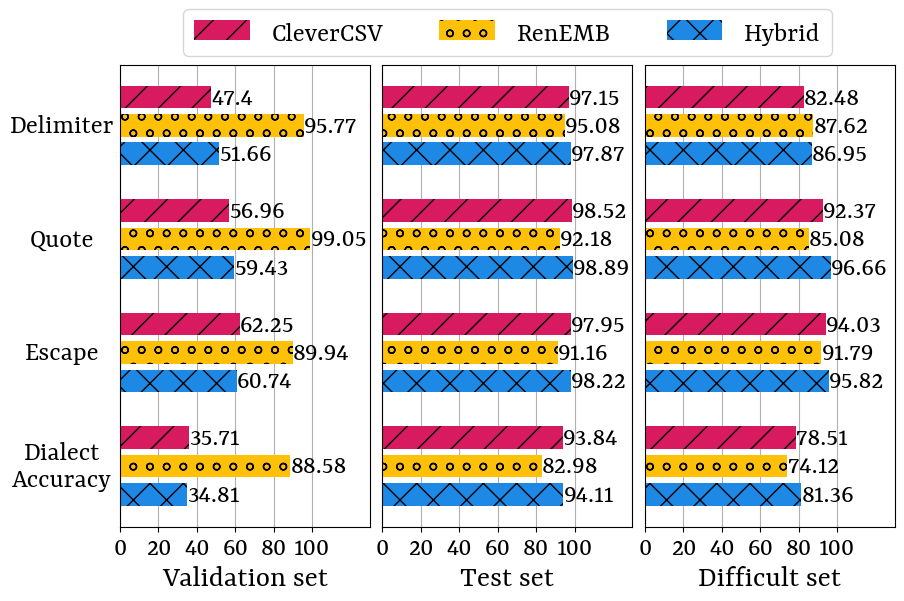

In [16]:
from matplotlib.patches import Patch

plt.rcParams['font.family'] = 'Rasa'
labelsize = 20

colors = [red, yellow, blue]
patterns = ['/', 'o', 'x']

def plot_bar(ax, title, bar1,bar2,bar3,bar4):
  ax.grid(zorder=-10)
  ax.set_axisbelow(True)

  ax.barh([0,1,2],    bar1, color=colors, hatch=patterns, xerr=std["magritte"][bar1.name])
  ax.barh([4,5,6],    bar2, color=colors, hatch=patterns, xerr=std["magritte"][bar2.name])
  ax.barh([8,9,10],   bar3, color=colors, hatch=patterns, xerr=std["magritte"][bar3.name])
  ax.barh([12,13,14], bar4, color=colors, hatch=patterns, xerr=std["magritte"][bar4.name])
  ax.invert_yaxis()
  # add a legend
  # plt.legend(['No augmentation', 'Synonym', 'Backtranslation'], loc='upper left', bbox_to_anchor=(1, 1), fontsize=labelsize)

  # write numbers on top of the bars
  ypad =0
  xpad=.02
  for j, bar in enumerate([bar1, bar2, bar3, bar4]):
    for i, v in enumerate(bar):
      ax.text(v+xpad, (j*4)+i+ypad, str(round(v, 2)), color='black', size=labelsize, va='center')


  # only have the corresponding x labels corresponding to the middle bar of each plot
  ax.set_yticks([])
  #
  ax.set_xlabel(title, size=labelsize+2);
  ticks = [0, 20, 40, 60, 80, 100]
  ax.set_xticks(ticks=ticks, labels=ticks,size=labelsize);
  ax.set_xlim(0, 130)
  # plt.title("Dialect detection results", size=labelsize+2);

fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(nrows=1,ncols=3, wspace=0.05)
axs = gs.subplots(sharey=True)

bars = [res[f"dev_f1_{x}"] for x in ["delimiter", "quotechar", "escapechar"]] + [res["dev_accuracy"]]
plot_bar(axs[0], 'Validation set', *bars)

# stack another plot on the right of the first one reusing the same y axis
bars = [res[f"test_f1_{x}"] for x in ["delimiter", "quotechar", "escapechar"]] + [res["test_accuracy"]]
plot_bar(axs[1], 'Test set', *bars)

bars = [res[f"weird_f1_{x}"] for x in ["delimiter", "quotechar", "escapechar"]] + [res["weird_accuracy"]]
plot_bar(axs[2], 'Difficult set', *bars)

xpoint = -30
axs[0].text(xpoint, 1, 'Delimiter', ha='center', va='center', size=labelsize)
axs[0].text(xpoint, 5, 'Quote', ha='center', va='center', size=labelsize)
axs[0].text(xpoint, 9, 'Escape', ha='center', va='center', size=labelsize)
axs[0].text(xpoint, 13, 'Dialect\nAccuracy', ha='center', va='center', size=labelsize)

# add a legend
custom_bars = [Patch(facecolor=colors[0], hatch=patterns[0]),
               Patch(facecolor=colors[1], hatch=patterns[1]),
               Patch(facecolor=colors[2], hatch=patterns[2]),]

axs[1].legend(handles=custom_bars,
              labels = ["CleverCSV", "RenEMB", "Hybrid"] , #[x.capitalize() for x in res.index],
              loc='center',
              bbox_to_anchor=(0.5, 1.07),
              ncols=3,
              fontsize=labelsize)

plt.savefig('dialect_new_results.png', dpi=300, bbox_inches='tight')

Magritte
F1 weighted:  0.9158393653887914
F1 macro:  0.2448001728770884
F1 micro:  0.9103825136612022
Clevercsv
F1 weighted:  0.3867685090175581
F1 macro:  0.163597996526876
F1 micro:  0.5046448087431694


c:\Users\Gerardo\miniconda3\envs\magritte\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12289 (\N{IDEOGRAPHIC COMMA}) missing from current font.
  fig.canvas.draw()
c:\Users\Gerardo\miniconda3\envs\magritte\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 12289 (\N{IDEOGRAPHIC COMMA}) missing from current font.
  func(*args, **kwargs)


3660
3503


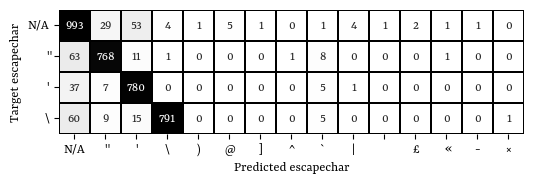

c:\Users\Gerardo\miniconda3\envs\magritte\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12289 (\N{IDEOGRAPHIC COMMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


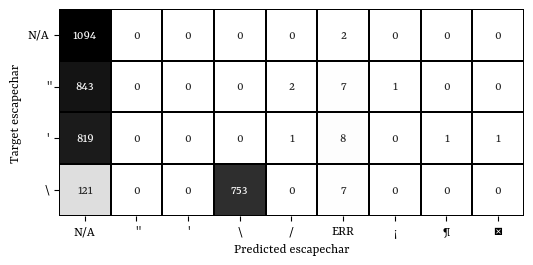

In [134]:
import contextlib
import seaborn as sns
import sklearn.metrics

# Test
# magritte_test = pd.read_csv("D:\\HPI\\docker\\csv_bert\\experiments\\finetune_dialect\\magritte_test_original_results.csv").fillna("")
# clevercs_test = pd.read_csv("D:\\HPI\\docker\\csv_bert\\experiments\\finetune_dialect\\clevercs_test_original_results.csv").fillna("")

# Weird
# magritte_weird = pd.read_csv("D:\\HPI\\docker\\csv_bert\\experiments\\finetune_dialect\\magritte_weird_original_results.csv").fillna("")
# clevercs_weird = pd.read_csv("D:\\HPI\\docker\\csv_bert\\experiments\\finetune_dialect\\clevercs_weird_original_results.csv").fillna("")

# magritte = pd.concat([magritte_test, magritte_weird], axis=0)
# clevercs = pd.concat([clevercs_test, clevercs_weird], axis=0)

def plot_cm(df, classification_class):
#plot a confusion matrix between the predicted_delimiter and the target_delimiter columns
    y_pred = df[f"predicted_{classification_class}"]
    y_true = df[f"target_{classification_class}"]
    labels = sorted(y_true.unique())
    labels += sorted([x for x in y_pred.unique() if x not in labels])
    matrix = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=labels)
    matrix = matrix[~np.all(matrix == 0, axis=1)]

    print("F1 weighted: ", sklearn.metrics.f1_score(y_true, y_pred, average="weighted"))
    print("F1 macro: ", sklearn.metrics.f1_score(y_true, y_pred, average="macro"))
    print("F1 micro: ", sklearn.metrics.f1_score(y_true, y_pred, average="micro"))

    with contextlib.suppress(ValueError):
        labels[labels.index("\x09")] = "\\t"
    with contextlib.suppress(ValueError):
        labels[labels.index('')] = "N/A"
    with contextlib.suppress(ValueError):
        labels[labels.index(" ")] = "\\s"
    with contextlib.suppress(ValueError):
        labels[labels.index("[UNK]")] = "ERR"
    # draw matrix in matplotlib
    fig, ax  = plt.subplots(figsize=(6, 6))
    # im = ax.matshow(matrix, cmap=plt.cm.Blues, alpha)
    sns.heatmap(matrix, 
                cmap='binary', 
                # vmin=0,
                # vmax=100,
                linecolor='black',
                linewidths=.25,
                robust=True,
                xticklabels=labels, 
                yticklabels=labels[:len(matrix[:,0])], 
                annot=True, 
                fmt='d', 
                cbar=False,
                square=True, 
                )

    # rotate the y ticks 90 degrees
    plt.yticks(rotation=0)
    ax.set_xlabel("Predicted "+classification_class)
    ax.set_ylabel("Target "+classification_class)

dataset ="dev"
print("Magritte")
plot_cm(results_df[dataset]["magritte"], "escapechar")

print("Clevercsv")
plot_cm(results_df[dataset]["clevercsv"], "escapechar")
# print()

df = results_df[dataset]["clevercsv"]
# select only rows if ""augmented" not in filename"
print(len(df))
df = df[df["filename"].str.contains("augmented")]
print(len(df))


Num unique dialects 180
Num unique delimiters 11
Num unique quotechars 5
Num unique escapechars 4
Magritte
F1 weighted:  0.9943784881216776
F1 macro:  0.44850872344362697
F1 micro:  0.9931693989071039
Clevercsv
F1 weighted:  0.5888410852483865
F1 macro:  0.43085590900020376
F1 micro:  0.5792349726775956


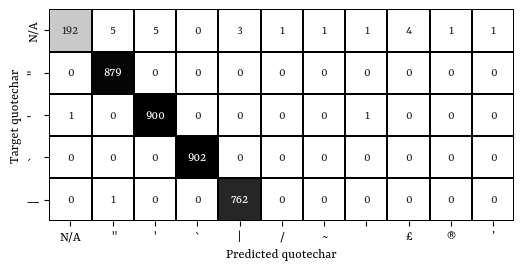

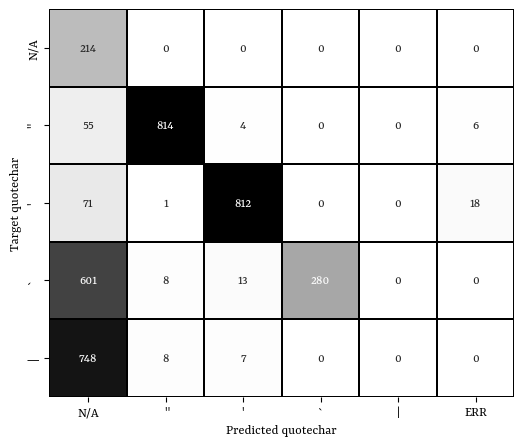

In [30]:
magritte["dialect"] = magritte["target_delimiter"] + magritte["target_quotechar"] + magritte["target_escapechar"]
dialects = magritte["dialect"].unique()
print("Num unique dialects", len(dialects))
print("Num unique delimiters", len(magritte["target_delimiter"].unique()))
print("Num unique quotechars", len(magritte["target_quotechar"].unique()))
print("Num unique escapechars", len(magritte["target_escapechar"].unique()))

print("Magritte")
plot_cm(magritte, "quotechar")
print("Clevercsv")
plot_cm(clevercs, "quotechar")


Magritte
F1 weighted:  0.9158393653887914
F1 macro:  0.2448001728770884
F1 micro:  0.9103825136612022
Clevercsv
F1 weighted:  0.3867685090175581
F1 macro:  0.163597996526876
F1 micro:  0.5046448087431694


c:\Users\Gerardo\miniconda3\envs\magritte\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 12289 (\N{IDEOGRAPHIC COMMA}) missing from current font.
  fig.canvas.draw()
c:\Users\Gerardo\miniconda3\envs\magritte\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 12289 (\N{IDEOGRAPHIC COMMA}) missing from current font.
  func(*args, **kwargs)


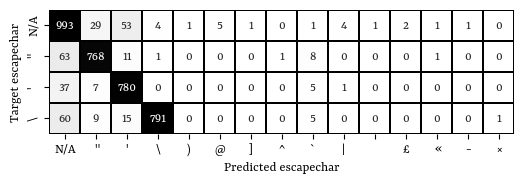

c:\Users\Gerardo\miniconda3\envs\magritte\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12289 (\N{IDEOGRAPHIC COMMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


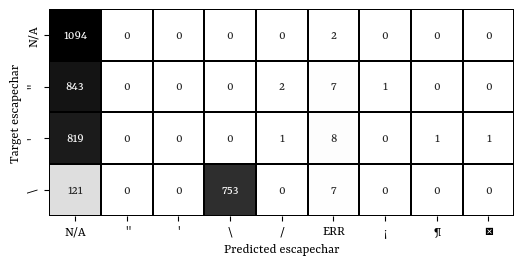

In [31]:
print("Magritte")
plot_cm(magritte, "escapechar")
print("Clevercsv")
plot_cm(clevercs, "escapechar")

In [188]:
# df = results_df["test"]["hybrid"]
df = results_df["test"]["magritte"]

df["accuracy"] = (df["predicted_delimiter"]== df["target_delimiter"]) &\
(df["predicted_quotechar"]== df["target_quotechar"]) &\
(df["predicted_escapechar"]== df["target_escapechar"])

# df[~df["accuracy"]]
df[(df["predicted_escapechar"]!= df["target_escapechar"])][["filename","predicted_escapechar","target_escapechar"]]

df["predicted_dialect"] = df["predicted_delimiter"] + df["predicted_quotechar"] + df["predicted_escapechar"]
df["dialect"] = df["target_delimiter"] + df["target_quotechar"] + df["target_escapechar"]
df.groupby("dialect").count()["filename"]
# df.groupby("predicted_dialect").count()["filename"]

Magritte accuracy 0.7900194426441997
Clevercsv accuracy 0.8930654569021387


[[210   0   2   0   2   0   0   0   0   0   0   0   0   0   0]
 [234 231 199   0   0   1   1 211   1   0   0   0   1   0   0]
 [242 227 231   0   0   0   0 200   0   0   0   1   0   1   0]
 [251 188 230  19   0   0   3 208   0   1   1   0   1   0   0]
 [216 167 197   0   3   0   1 177   0   0   0   1   0   0   1]]


<Axes: >

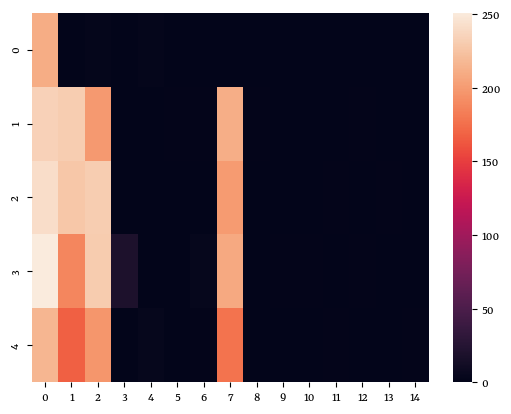